# Advance Lane Detection

In [1]:
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# debug functions to easily display a test image
def display_to(img, dst):
    if len(img.shape) == 3 and img.shape[2] == 3:
        dst.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif len(img.shape) == 3 and img.shape[2] == 1:
        dst.imshow(img[:,:,0],cmap='gray')
    else:
        dst.imshow(img, cmap='gray')

def display_image(img):
    plt.figure()
    display_to(img, plt)
    plt.axis('off')
    plt.show()
    
def display_images(left, right):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,6))  
    display_to(left, axes[0])
    display_to(right, axes[1])
    for ax in axes:
        ax.axis('off')
    plt.show()

## Camera Calibration

In [3]:
CALIBRATION_DIR = 'camera_cal/'
CALIBRATION_MASK = 'calibration*.jpg'
GRID_X=9
GRID_Y=6

In [4]:
import json
import glob
import os.path

class Camera:
    def __init__(self, name = 'camera'):
        self.name = name
        self.camera_matrix = None
        self.dist_coeffs = None
        
    def calibrate(self, path_mask, grid_x, grid_y):
        # try loading the results from a previous calibration
        if self.load():
            return True
        
        # calibrate the camera
        print('Calibrating camera using images from ' + path_mask)
        
        objpoints = []
        imgpoints = []
        img_shape = None

        # prepare object points
        objp = np.zeros((grid_x*grid_y,3), np.float32)
        objp[:,:2] = np.mgrid[0:grid_x,0:grid_y].T.reshape(-1, 2)
                
        # process all calibration images
        for filename in glob.glob(path_mask):
            
            print ('... processing image ' + filename, end='')

            img = cv2.imread(filename)
    
            # skip invalid images
            if img is None:
                continue
        
            if img_shape is None:
                img_shape = img.shape[0:2]
    
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
            found, corners = cv2.findChessboardCorners(gray, (grid_x, grid_y), None)
    
            if found: 
                objpoints.append(objp)
                imgpoints.append(corners)
                print(' ... OK')
            else:
                print(' ... skipped')
    
        # end for (filenames)
        
        # compute camera-matrix and distance coefficients
        cal_ok, self.camera_matrix, self.dist_coeffs, rvecs, tvecs = \
            cv2.calibrateCamera(objpoints, imgpoints, img_shape[0:2], None, None)

        if cal_ok:
            self.save()
            return True
        
        return False
    
    def undistort(self, src_img):
        return cv2.undistort(src_img, self.camera_matrix, self.dist_coeffs, None, self.camera_matrix)
        
    def save(self):
        with open(self.name + '.json', 'w') as f:
            json.dump({'matrix' : self.camera_matrix.tolist(),
                       'dist' : self.dist_coeffs.tolist()}, f)
    
    def load(self):
        if not os.path.isfile(self.name + '.json'):
            return False
    
        print('Loading calibration data')
        with open(self.name + '.json', 'r') as f:
            data = json.load(f)
            self.camera_matrix = np.array(data['matrix'])
            self.dist_coeffs = np.array(data['dist'])
            return True
            
        

In [ ]:
camera = Camera('camera_udacity')
if not camera.calibrate(CALIBRATION_DIR + CALIBRATION_MASK, GRID_X, GRID_Y):
    print ("ERROR CALIBRATING CAMERA")

## Undistort

In [ ]:
img = cv2.imread('test_images/straight_lines1.jpg')
corrected = camera.undistort(img)
display_images(img, corrected)

## Perspective transformation

In [5]:
class ImagePipeline:
    def __init__(self):
        self.compute_perspective_transform()
        self.camera = Camera('camera_udacity')
        if not self.camera.calibrate(CALIBRATION_DIR + CALIBRATION_MASK, GRID_X, GRID_Y):
            print ("ERROR CALIBRATING CAMERA")
                
    def compute_perspective_transform(self):
        src_points = np.float32([[ 230, 700], 
                                 [ 560, 470], 
                                 [ 730, 470], 
                                 [1090, 700]])
        dst_points = np.float32([[ 350, 720], 
                                 [ 350,   0], 
                                 [ 980,   0], 
                                 [ 980, 720]])
        
        self.persp_M = cv2.getPerspectiveTransform(src_points, dst_points)
        self.persp_Minv = cv2.getPerspectiveTransform(dst_points, src_points)
        
    def undistort(self, img):
        return self.camera.undistort(img)
        
    def transform_topdown(self, img):
        return cv2.warpPerspective(img, self.persp_M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def gradient_treshold(self, img, t_min=20, t_max=100):
        # absolute value of derivatie in x (accentuates more vertical lines)
        sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0)) 
        scaled_sobelx = np.uint8(255*sobelx/np.max(sobelx))
        
        # threshold x gradient
        mask = np.zeros_like(scaled_sobelx)
        mask[(scaled_sobelx >= t_min) & (scaled_sobelx <= t_max)] = 1
        
        return mask
    
    def color_treshold(self, img, c_min=175, c_max=255):
        mask = np.zeros_like(img)
        mask[(img >= c_min) & (img < c_max)] = 1
        return mask
        
    
    def treshold(self, img):
        # convert image to HLS colorspace
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        # take the luminance channel and apply a gradient treshold
        # XXX saturation seems the give a better result
        g_mask = self.gradient_treshold(hls[:,:,2])
                
        # take the saturation channel and apply a color treshold
        c_mask = self.color_treshold(hls[:,:,2])
        
        # combine the masks
        mask = np.zeros_like(g_mask)
        mask[(g_mask == 1) | (c_mask == 1)] = 1
        
        return mask
    
    def detect_lane_lines(self, img_mask):
        
        # fill some shorthand variables
        img_w, img_h = (img_mask.shape[1], img_mask.shape[0])
        
        window_n = 9
        window_w = 200
        window_d = window_w // 2
        window_h = img_h // window_n
        recenter_min = 50
        
        # save the indices of the active pixels in the mask
        active_y, active_x = np.nonzero(img_mask)
                
        # create a RGB output image to draw on and  visualize the result
        out_img = np.dstack((img_mask, img_mask, img_mask)) * 255
               
        # compute the histogram of the lower half of the image (sum each column)
        hist = np.sum(img_mask[img_h//2:,:], axis=0)
        
        # get the position of the peak in the left and right half of the histogram
        center_x = np.int(img_w / 2)
        
        c_left   = np.argmax(hist[:center_x])
        c_right  = np.argmax(hist[center_x:]) + center_x
        y_max    = img_h
        y_min    = y_max - window_h
        
        # indices into the active_x/y arrays of points that fall with the sliding windows
        l_lane_indices = []
        r_lane_indices = []
        
        for window in range(window_n):
            # compute horizontal edges of the window
            l_x_min = c_left - window_d
            l_x_max = c_left + window_d
            r_x_min = c_right - window_d
            r_x_max = c_right + window_d
                     
            # visualisation
            cv2.rectangle(out_img, (l_x_min, y_min), (l_x_max, y_max), (0, 255, 0), 2)
            cv2.rectangle(out_img, (r_x_min, y_min), (r_x_max, y_max), (0, 255, 0), 2)
            
            # save coordinates of the detected pixels in the windows            
            l_inds = ((active_y >= y_min) & (active_y < y_max) & (active_x >= l_x_min) & (active_x < l_x_max)).nonzero()[0]
            r_inds = ((active_y >= y_min) & (active_y < y_max) & (active_x >= r_x_min) & (active_x < r_x_max)).nonzero()[0]
                    
            l_lane_indices.append(l_inds)
            r_lane_indices.append(r_inds)
        
            # recenter the windows ?
            if len(l_inds) > recenter_min:
                c_left = np.int(np.mean(active_x[l_inds]))
            if len(r_inds) > recenter_min:
                c_right = np.int(np.mean(active_x[r_inds]))
            
            # move to the next vertical slice
            y_max = y_min
            y_min = y_max - window_h
            
        # lane indices are arrays of arrays: concatenate into 1 array
        l_lane_indices = np.concatenate(l_lane_indices)
        r_lane_indices = np.concatenate(r_lane_indices)
        
        # color the detected pixels
        out_img[active_y[l_lane_indices], active_x[l_lane_indices]] = [255, 0, 0]
        out_img[active_y[r_lane_indices], active_x[r_lane_indices]] = [0, 0, 255]
        
        # fit second order polynomal functions to the points
        l_lane = np.polyfit(active_y[l_lane_indices], active_x[l_lane_indices], 2)
        r_lane = np.polyfit(active_y[r_lane_indices], active_x[r_lane_indices], 2)
        
        # (debug) draw the polynomals
        plot_y  = np.linspace(0, img_h-1, img_h)
        plot_lx = l_lane[0]*plot_y**2 + l_lane[1]*plot_y + l_lane[2]
        plot_rx = r_lane[0]*plot_y**2 + r_lane[1]*plot_y + r_lane[2]
        
        plot_l = np.transpose(np.vstack([plot_lx, plot_y]))
        plot_r = np.transpose(np.vstack([plot_rx, plot_y]))
        
        cv2.polylines(out_img, [np.int32(plot_l)], False, [0,255,255], 4)
        cv2.polylines(out_img, [np.int32(plot_r)], False, [0,255,255], 4)
        
        # create a new image to draw the lane on
        layer_zero  = np.zeros_like(img_mask).astype(np.uint8)
        lane_output = np.dstack((layer_zero, layer_zero, layer_zero))
        
        points = np.concatenate((np.int32(plot_l), np.int32(np.flipud(plot_r))))
        cv2.fillPoly(lane_output, [points], (0,255,0))
        
        # reproject to the original space
        lane_unwarp = cv2.warpPerspective(lane_output, self.persp_Minv, (img_w, img_h))
        return lane_unwarp        
    
    def run(self, img):
        corrected = self.undistort(img)
        top_down = self.transform_topdown(corrected)
        mask = self.treshold(top_down)
        
        lane_img = self.detect_lane_lines(mask)
        
        return cv2.addWeighted(corrected, 1, lane_img, 0.3, 0)

        
       
#example = np.copy(corrected)
#cv2.polylines(example, [np.int32(src_points)], True, [0, 0, 255], 5)
#display_image(example)


In [55]:
pipeline = ImagePipeline()

Loading calibration data


In [ ]:
for file in glob.glob('test_images/*.jpg'):
    img = cv2.imread(file)
    
    print (file)
    corrected = pipeline.undistort(img)
    topdown = pipeline.transform_topdown(corrected)
    display_images(corrected, topdown)


## Gradient treshold

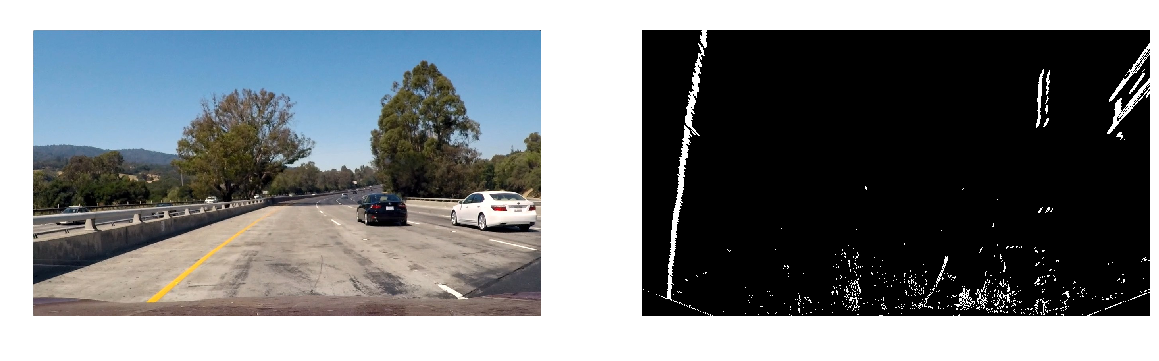

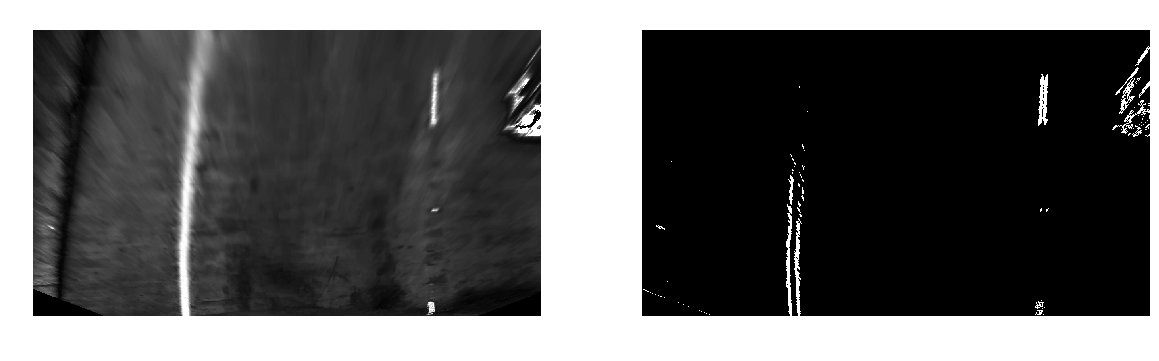

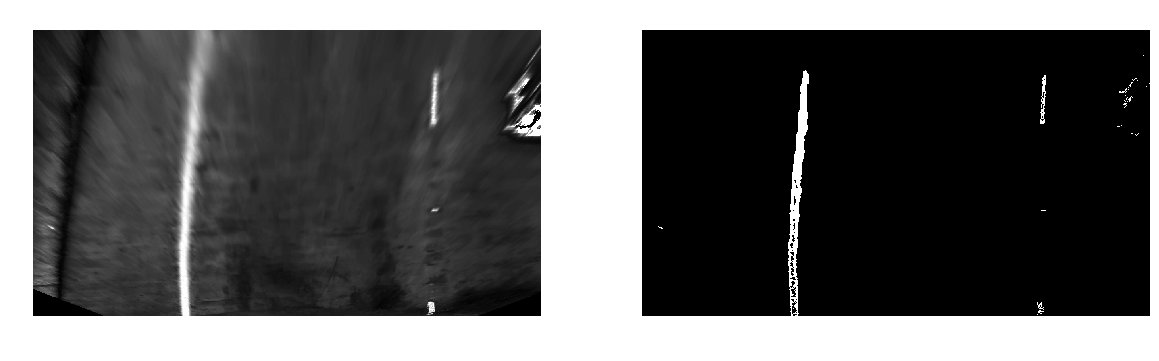

In [52]:
img = cv2.imread('test_images/test1.jpg')
corrected = pipeline.undistort(img)
topdown = pipeline.transform_topdown(corrected)

# convert to grayscale (XXX try luminance channel of HLS)
gray = cv2.cvtColor(topdown, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(topdown, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

binary = pipeline.gradient_treshold(gray, 20, 100)
display_images(img, binary)

#display_images(H, pipeline.gradient_treshold(H))
#display_images(L, pipeline.gradient_treshold(L))
display_images(S, pipeline.gradient_treshold(S))
#display_images(gray, pipeline.gradient_treshold(gray))
display_images(S, pipeline.color_treshold(S))

test_images\straight_lines1.jpg


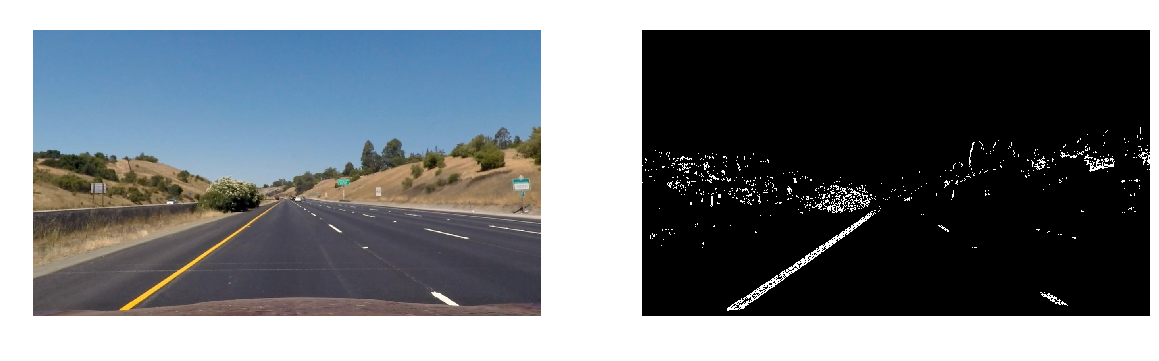

test_images\straight_lines2.jpg


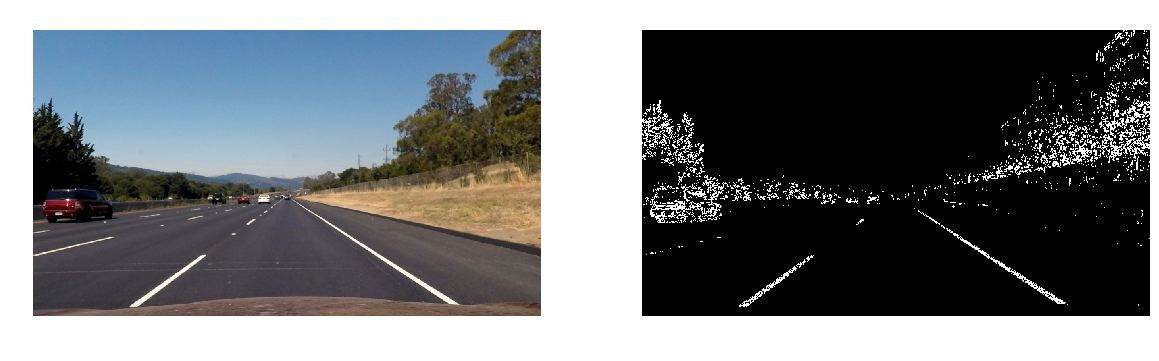

test_images\test1.jpg


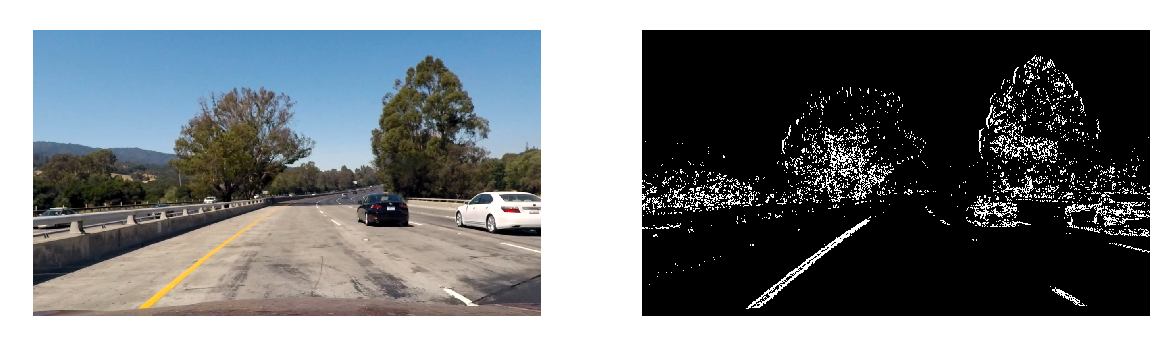

test_images\test2.jpg


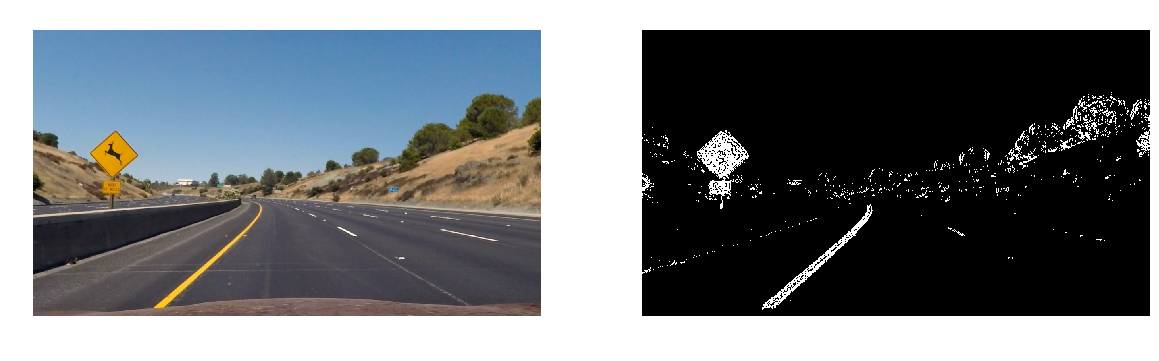

test_images\test3.jpg


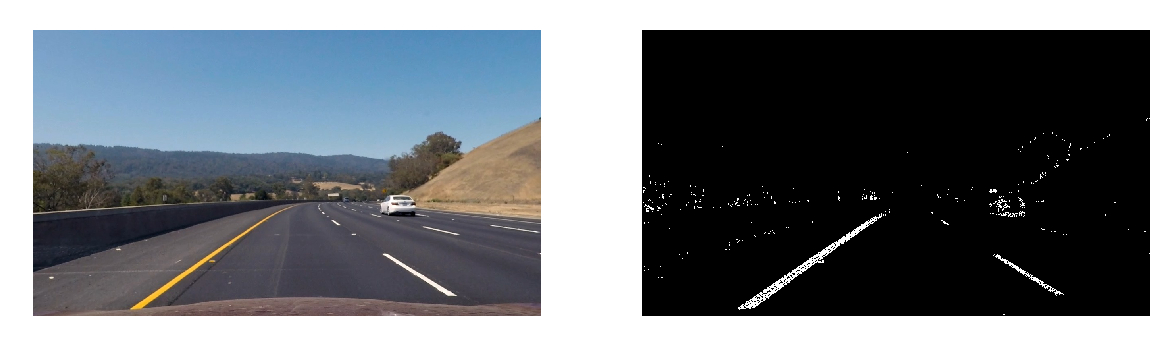

test_images\test4.jpg


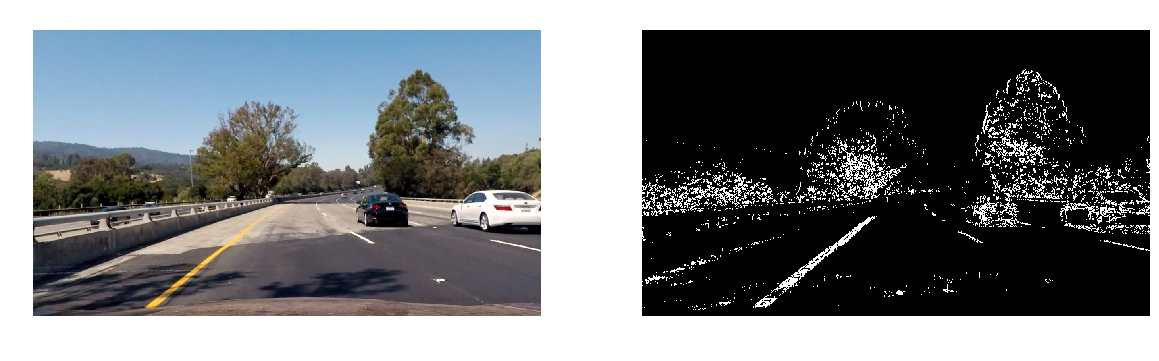

test_images\test5.jpg


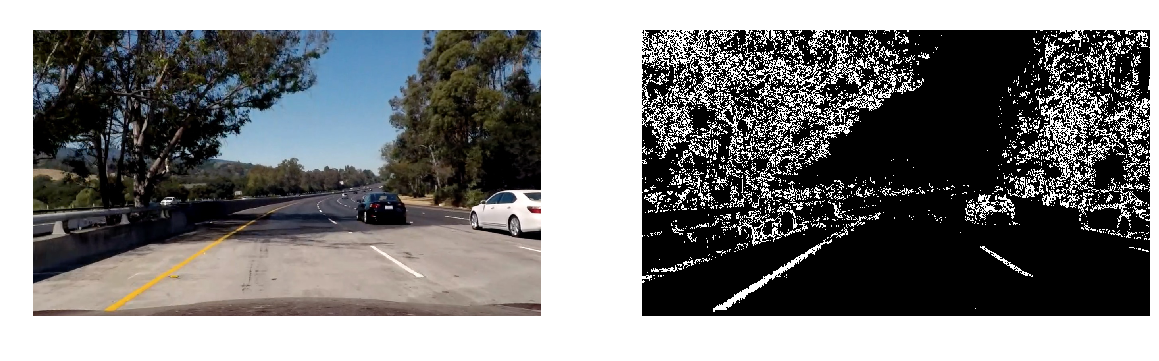

test_images\test6.jpg


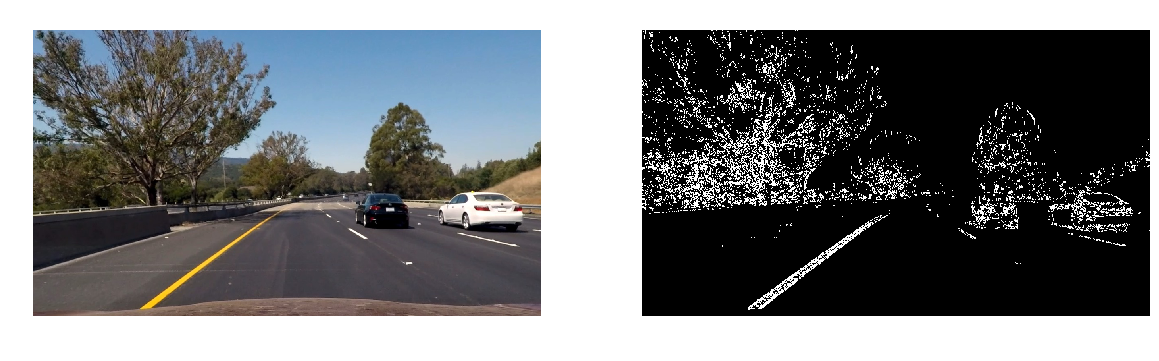

In [56]:
for file in glob.glob('test_images/*.jpg'):
    print (file)
    img = cv2.imread(file)    
    
    corrected = pipeline.undistort(img)
    mask = pipeline.treshold(corrected)
    display_images(corrected, mask)


## Detect Lane Lines

Loading calibration data
test_images\straight_lines1.jpg


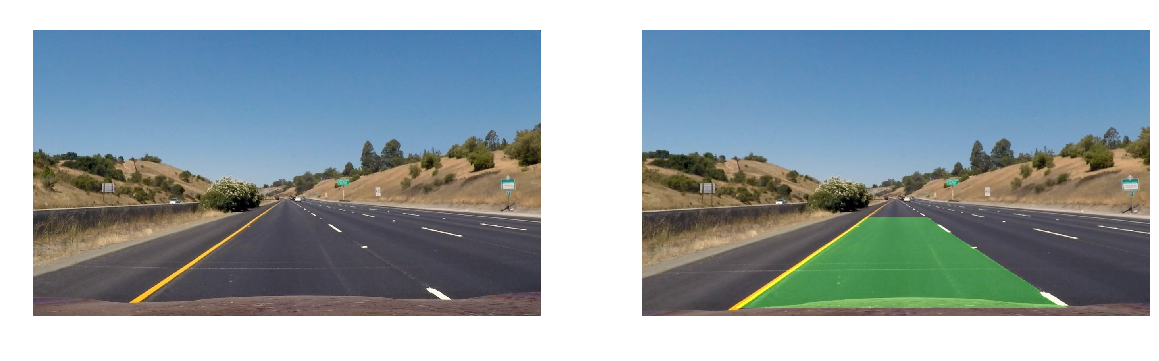

test_images\straight_lines2.jpg


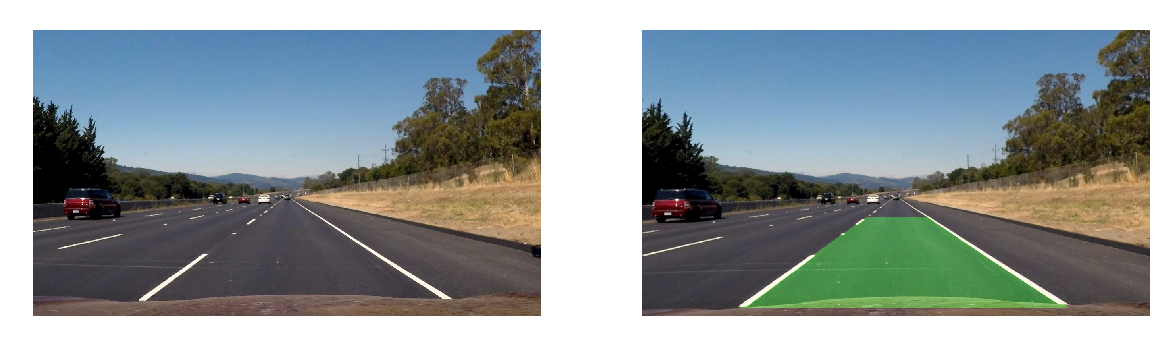

test_images\test1.jpg


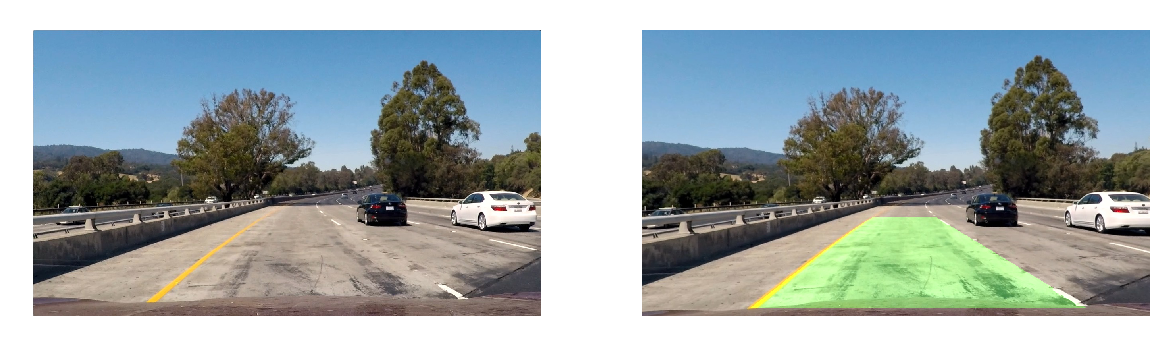

test_images\test2.jpg


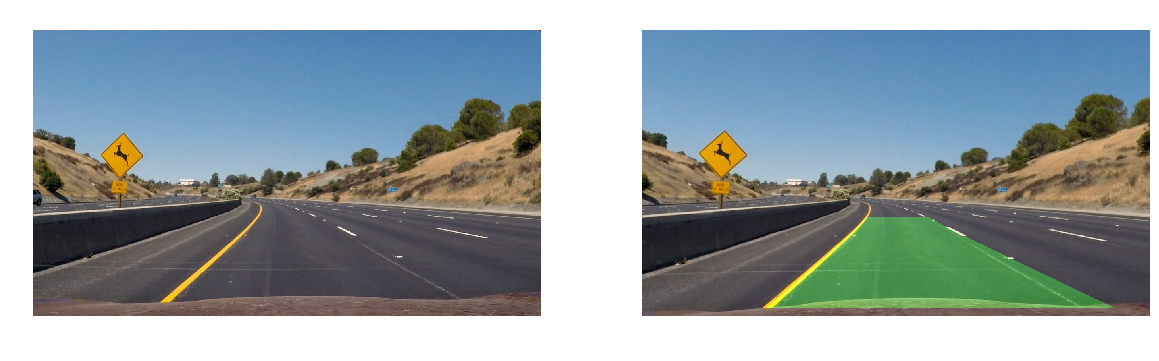

test_images\test3.jpg


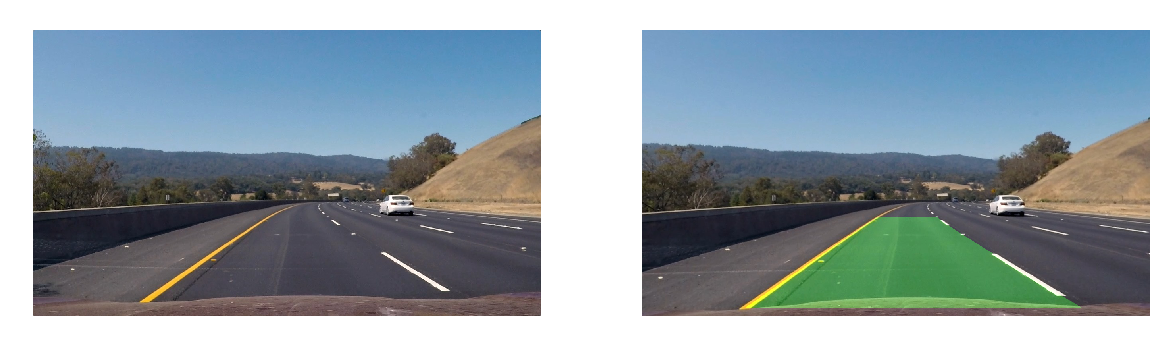

test_images\test4.jpg


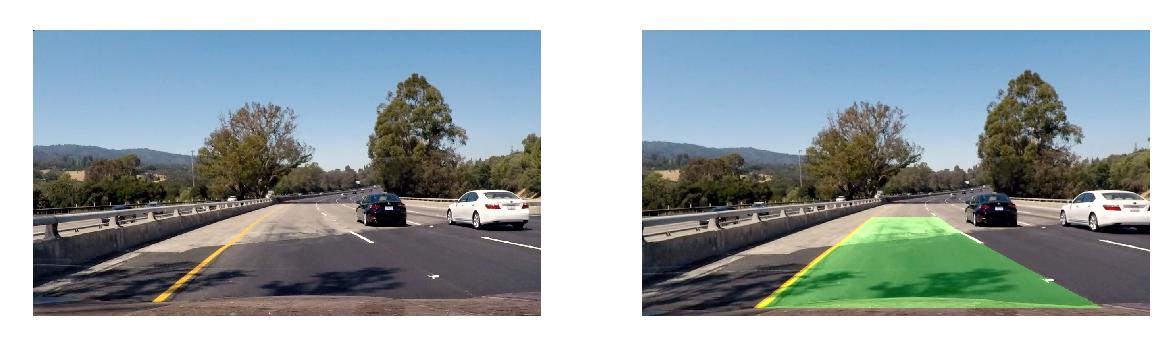

test_images\test5.jpg


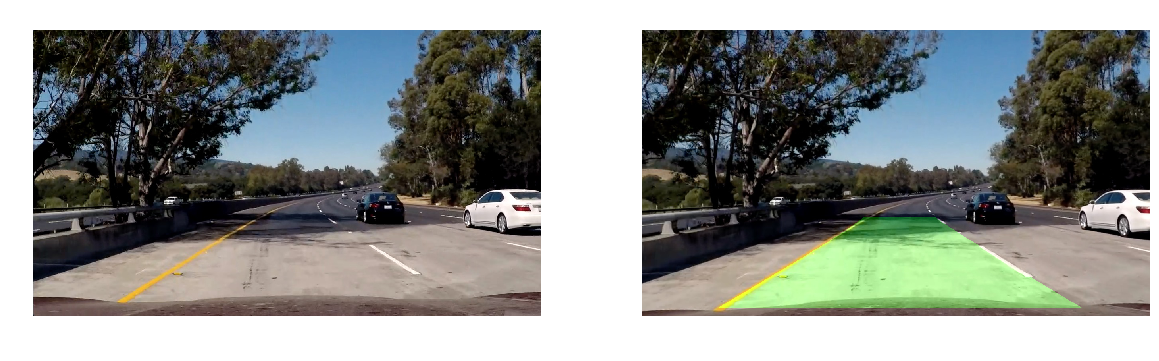

test_images\test6.jpg


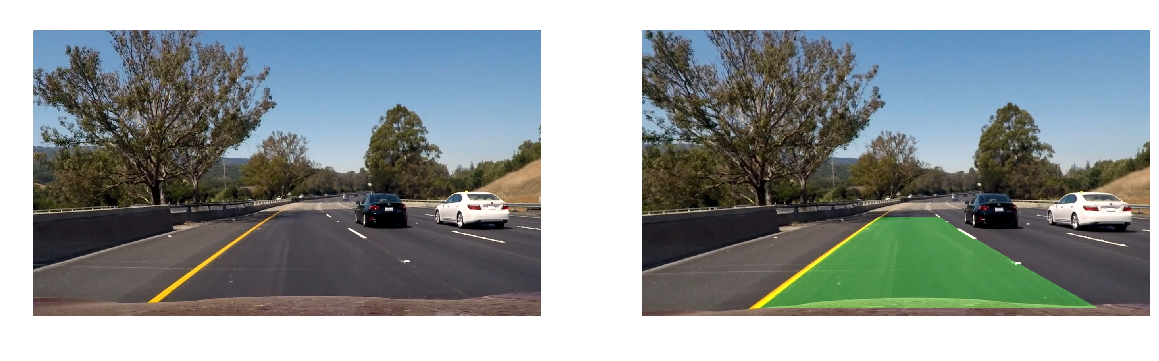

In [57]:
pipeline = ImagePipeline()

import time

for file in glob.glob('test_images/*.jpg'):
    print (file)
    img = cv2.imread(file)

    detected = pipeline.run(img)
    display_images(img, detected)
    
    time.sleep(1)

## Video

In [7]:
from moviepy.editor import VideoFileClip

pipeline = ImagePipeline()

Loading calibration data


In [12]:
def process_image(img):
    return pipeline.run(img)
    
def process_video(filename):
    i_clip = VideoFileClip(filename)
    o_clip = i_clip.fl_image(process_image)
    %time o_clip.write_videofile('output_images/' + filename, audio=False)

In [13]:
process_video('project_video.mp4')

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:03<00:00, 10.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 2min 4s


In [14]:
process_video('challenge_video.mp4')

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


  1%|▋                                                                                                     | 3/485 [00:00<00:47, 10.18it/s]

TypeError: expected non-empty vector for x